In [1]:
from IPython.display import display, HTML
display(HTML("<style>:root { --jp-notebook-max-width: 95% !important; }</style>"))
display(HTML("<style>.container { width: 95% !important; }</style>"))

In [20]:
from matplotlib import pyplot as plt
from PIL import Image
import os
import shutil
import json
import numpy as np
import pandas as pd
import albumentations as A
import tensorflow as tf
import pickle
import glob

from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras import initializers
from tensorflow.keras import optimizers
from tensorflow.keras.metrics import TopKCategoricalAccuracy
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import *

from sklearn.metrics import top_k_accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as plt_cm
from PIL import Image as PILIm

In [3]:
def categorical_focal_loss(alpha, gamma=2.):
    """
    model.compile(loss=[categorical_focal_loss(alpha=[[.25, .25, .25]], gamma=2)], metrics=["accuracy"], optimizer=adam)
    """
    alpha = np.array(alpha, dtype=np.float32)
    def categorical_focal_loss_fixed(y_true, y_pred):
        # Clip the prediction value to prevent NaN's and Inf's
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        # Calculate Cross Entropy
        cross_entropy = -y_true * K.log(y_pred)
        # Calculate Focal Loss
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy
        # Compute mean loss in mini_batch
        return K.mean(K.sum(loss, axis=-1))
    return categorical_focal_loss_fixed

In [54]:
class KerasModel:
    def __init__(self, num_classes, input_shape=(256, 256, 3), safe_augmentation=False, **kwargs):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model = None
        self.safe_augmentation = safe_augmentation
        self.config = kwargs
        self.setup()
        seq = [x for x in [self.l_base, self.l_head] if x is not None]
        for i, layer in enumerate(seq):
            if i == 0: x = layer(self.l_input)
            else: x = layer(x)
        if seq:
            self.model = Model(inputs=self.l_input, outputs=x)
        self.generator_train = ImageDataGenerator(
            preprocessing_function=lambda x: self.preprocess_image(x, True)
        )
        self.generator_valid = ImageDataGenerator(
            preprocessing_function=lambda x: self.preprocess_image(x, False)
        )
    
    def fit(self, directory, epochs=5, batch_size=32):
        train_generator = self.generator_train.flow_from_directory(
            f"{directory}/train", batch_size=batch_size,
            target_size=(self.input_shape[0], self.input_shape[1])
        )
        validation_generator = self.generator_valid.flow_from_directory(
            f"{directory}/valid", batch_size=batch_size,
            target_size=(self.input_shape[0], self.input_shape[1]),
        )
        return self.model.fit(train_generator, epochs=epochs, validation_data=validation_generator, verbose=1)
    
    def setup(self):
        self.l_input = Input(shape=self.input_shape)
        self.f_augmentor = self._augmentor()
        self.f_external = self._external()
        self.l_base = self._base()
        self.l_head = self._head()
        
    def _augmentor(self):
        if self.safe_augmentation:
            return A.Compose([
                A.HorizontalFlip(p=0.5),
                A.Sharpen(p=.5, lightness=(1, 1)),
                A.ShiftScaleRotate(rotate_limit=15, p=1),
                A.Resize(self.input_shape[0], self.input_shape[1], always_apply=True)
            ]) 
        else:
            return A.Compose([
                A.HorizontalFlip(p=0.5),
                A.UnsharpMask(p=0.5),
                A.ZoomBlur(max_factor=1.05, p=.5),
                A.Spatter(intensity=0.1, p=.5),
                A.Sharpen(p=.5),
                A.Defocus(radius=3, p=0.1),
                A.RandomFog(fog_coef_lower=0.0, fog_coef_upper=0.2, p=0.5),
                A.MedianBlur(blur_limit=5, p=0.3),
                A.GaussianBlur(p=0.1),
                A.GaussNoise(p=0.1),
                A.ShiftScaleRotate(rotate_limit=15, p=1),
                A.Resize(self.input_shape[0], self.input_shape[1], always_apply=True)
            ])
    
    def _external(self):
        return None
    
    def preprocess_image(self, image, for_training=True):
        if for_training and self.f_augmentor:
            image = self.f_augmentor(image=image)['image']
        if self.f_external:
            image = self.f_external(image)
        return image
        
    def _base(self):
        return None
    
    def _head(self):
        return None
    
    def compile(self, optimizer="adam", loss=None):
        if not self.model: return
        topk1 = TopKCategoricalAccuracy(k=1, name="topk1")
        topk2 = TopKCategoricalAccuracy(k=2, name="topk2")
        topk3 = TopKCategoricalAccuracy(k=2, name="topk3")
        if loss is None: loss = categorical_focal_loss(alpha=[[1/self.num_classes for i in range(self.num_classes)]], gamma=2)
        self.model.compile(optimizer=optimizer, loss=loss, metrics=[topk1, topk2, topk3])
    
    def summary(self):
        if self.model: self.model.summary()

---

In [11]:
for folder in glob.glob("../data_prep/royalnavy/all/*"):
    print(
        os.path.basename(folder),
        len([g for g in glob.glob(f"{folder}/*.jpg")])
    )

cruiser 546
corvette 30
battleship 339
destroyer 827
frigate 402
submarine 148
carrier 208
minesweeper 271
desktop.ini 0


---

In [55]:
augmentor = KerasModel(num_classes=8, safe_augmentation=False)._augmentor()
augmentor_safe = KerasModel(num_classes=8, safe_augmentation=True)._augmentor()

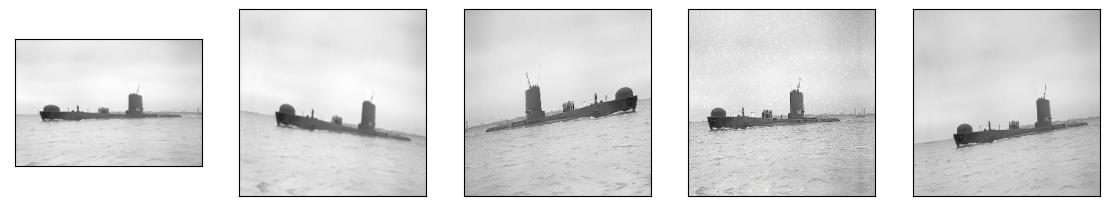

In [61]:
files = [
    #"battleship/portraits__HMS_Agamemnon_Battleship_1906.jpg.jpg",
    #"destroyer/portraits__HMS_Capel_destroyer_1943.jpg.jpg",
    "submarine/royalnavy-1__submarine__Alcide HMS 1.1964 W&L 1209J.jpg.jpg",
]

labels = ["HMS Agamemnon (battleship, 1906)", "HMS Capel (destroyer, 1943)", "HMS Alcide (submarine, 1964)"]

transformations = 4

plt.rcParams.update({'font.size': 12})

fig, axs = plt.subplots(len(files), transformations+1, figsize=(14, 10))

for f, file in enumerate(files):
    pil_image = PILIm.open(f"../data_prep/royalnavy-nowhite/all/{file}")
    axs[0].imshow(pil_image)
    axs[0].get_xaxis().set_visible(False)
    axs[0].get_yaxis().set_visible(False)
    for i in range(transformations):
        image = np.array(pil_image)
        axs[i+1].imshow(augmentor(image=image)['image'])
        axs[i+1].get_xaxis().set_visible(False)
        axs[i+1].get_yaxis().set_visible(False)
        #if i == 1: axs[f,i+1].title.set_text(labels[f])
        
plt.show()

---

In [62]:
results = {}

for result in glob.glob("../models/*.results.pickle"):
    r = pickle.load(open(result, "rb"))
    results[result] = r

In [63]:
def get_labels(segmented=False):
    generator = ImageDataGenerator()
    if not segmented:
        test_generator = generator.flow_from_directory(
            f"../data_prep/royalnavy-nowhite/valid", batch_size=1,
            shuffle=False,
        )
    else:
        test_generator = generator.flow_from_directory(
            f"../data_prep/royalnavy/valid", batch_size=1,
            shuffle=False,
        )
    return test_generator.labels

In [64]:
clean_results = []

for name, res in results.items():
    split = name.replace("../models\\", "").replace(".results.pickle", "").split("-")
    name, config = split[0], split[1:]
    if len(res) == 3:
        # old style results
        y, y_nw = res[1], res[2]
        y_pred = y if "segmented=1" in config else y_nw
        y_true = get_labels("segmented=1" in config)
    else:
        yt, ytnw, yp, ypnw = res
        y_pred = yp if "segmented=1" in config else ypnw
        y_true = yt if "segmented=1" in config else ytnw
    clean_results.append({
        "model": name,
        "focal": "focal=1" in config,
        "external": "external=1" in config,
        "segmented": "segmented=1" in config,
        "acc-1": top_k_accuracy_score(y_true, y_pred, k=1),
        "acc-2": top_k_accuracy_score(y_true, y_pred, k=2),
        "acc-3": top_k_accuracy_score(y_true, y_pred, k=3),
    })

df = pd.DataFrame.from_records(clean_results)
df.head()

Found 564 images belonging to 8 classes.
Found 584 images belonging to 8 classes.
Found 564 images belonging to 8 classes.
Found 564 images belonging to 8 classes.
Found 584 images belonging to 8 classes.
Found 564 images belonging to 8 classes.
Found 584 images belonging to 8 classes.
Found 564 images belonging to 8 classes.
Found 584 images belonging to 8 classes.
Found 564 images belonging to 8 classes.
Found 564 images belonging to 8 classes.
Found 584 images belonging to 8 classes.
Found 564 images belonging to 8 classes.
Found 584 images belonging to 8 classes.
Found 564 images belonging to 8 classes.
Found 584 images belonging to 8 classes.
Found 564 images belonging to 8 classes.
Found 564 images belonging to 8 classes.
Found 584 images belonging to 8 classes.
Found 564 images belonging to 8 classes.
Found 584 images belonging to 8 classes.
Found 564 images belonging to 8 classes.
Found 584 images belonging to 8 classes.
Found 564 images belonging to 8 classes.
Found 564 images

model  focal  external  segmented     acc-1     acc-2     acc-3
0  basic_grey  False     False      False  0.306738  0.476950  0.609929
1  basic_grey  False     False       True  0.320205  0.491438  0.636986
2  basic_grey  False      True      False  0.308511  0.450355  0.608156
3  basic_grey   True     False      False  0.308511  0.468085  0.604610
4  basic_grey   True     False       True  0.320205  0.491438  0.633562

In [128]:
df.to_csv("../data/results.csv")

---

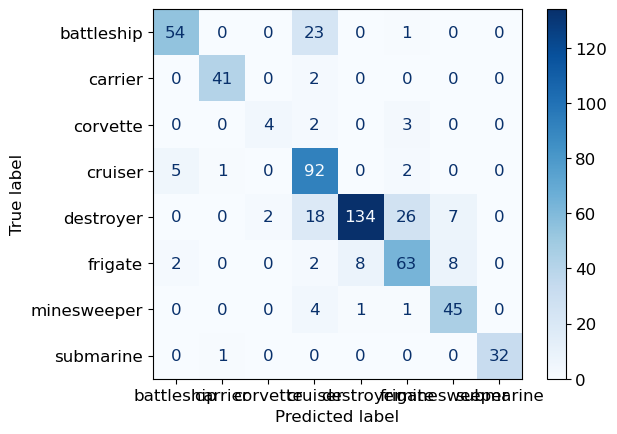

In [65]:
y_true, _, y_pred, _ = results["../models\\convnextl-focal=0-external=0-segmented=1.results.pickle"]

labels = ["battleship", "carrier", "corvette", "cruiser", "destroyer", "frigate", "minesweeper", "submarine"]

cm = confusion_matrix(y_true, np.argmax(y_pred, axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.show()

In [10]:
cm

array([[ 54,   0,   0,  23,   0,   1,   0,   0],
       [  0,  41,   0,   2,   0,   0,   0,   0],
       [  0,   0,   4,   2,   0,   3,   0,   0],
       [  5,   1,   0,  92,   0,   2,   0,   0],
       [  0,   0,   2,  18, 134,  26,   7,   0],
       [  2,   0,   0,   2,   8,  63,   8,   0],
       [  0,   0,   0,   4,   1,   1,  45,   0],
       [  0,   1,   0,   0,   0,   0,   0,  32]], dtype=int64)

In [72]:
model = tf.keras.models.load_model(
    '../models/convnextl-focal=0-external=0-segmented=1.keras',
    custom_objects={
        "categorical_focal_loss_fixed": categorical_focal_loss(alpha=[1/8 for i in range(8)]),
        "LayerScale": LayerScale
    }
)

for file in glob.glob("../data_prep/royalnavy/valid/submarine/*.jpg"):
    print(file)
    img_array = get_img_array(file, size=(224, 224, 3))
    pred = model.predict([img_array])
    print(np.argmax(pred[0]))

../data_prep/royalnavy/valid/submarine\portraits__HMS_Dardanelles_submarine.jpg.jpg
1/1 [==============================] - 5s 5s/step
7
../data_prep/royalnavy/valid/submarine\portraits__HMS_Perseus_Submarine_1932.jpg.jpg
1/1 [==============================] - 0s 249ms/step
7
../data_prep/royalnavy/valid/submarine\royalnavy-1__submarine__Acheron HMS submarine 2_1955 WL 1119H.jpg.jpg
1/1 [==============================] - 0s 56ms/step
7
../data_prep/royalnavy/valid/submarine\royalnavy-1__submarine__Alderny HMS 8.8.1949  W&L 1004C.jpg.jpg
1/1 [==============================] - 0s 58ms/step
7
../data_prep/royalnavy/valid/submarine\royalnavy-1__submarine__Alliance HMs submarine 9_1967 W&L 1070N .jpg.jpg
1/1 [==============================] - 0s 58ms/step
7
../data_prep/royalnavy/valid/submarine\royalnavy-1__submarine__Artemis HMS 3.1960 A class Sub with Deck Gun W&L 1059K.jpg.jpg
1/1 [==============================] - 0s 58ms/step
7
../data_prep/royalnavy/valid/submarine\royalnavy-1__submar

---

In [70]:
def get_img_array(img_path, size):
    img = tf.keras.utils.load_img(img_path, target_size=size)
    array = tf.keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(grad_model, img_array, pred_index=None):
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    # gradient of the output neuron (top predicted or chosen) with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)
    # vector where each entry is the mean intensity of the gradient over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    # multiply each channel in the feature map array by its importance with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    # normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def decode_predictions(preds, top=1):
    return np.argmax(preds, axis=1)

def display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.2):
    img = tf.keras.utils.load_img(img_path)
    img = tf.keras.utils.img_to_array(img)
    heatmap = np.uint8(255 * heatmap)
    jet = plt_cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.utils.img_to_array(jet_heatmap)
    superimposed_img = jet_heatmap * alpha + img * alpha
    superimposed_img = tf.keras.utils.array_to_img(superimposed_img)
    superimposed_img.save(cam_path)
    display(Image(cam_path))
    
def get_gradcam(img_path, heatmap, alpha=0.2):
    img = tf.keras.utils.load_img(img_path)
    img = tf.keras.utils.img_to_array(img)
    heatmap = np.uint8(255 * heatmap)
    jet = plt_cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.utils.img_to_array(jet_heatmap)
    superimposed_img = jet_heatmap * alpha + img * alpha
    superimposed_img = tf.keras.utils.array_to_img(superimposed_img)
    return superimposed_img

In [68]:
class LayerScale(Layer):
    def __init__(self, init_values, projection_dim, **kwargs):
        super().__init__(**kwargs)
        self.init_values = init_values
        self.projection_dim = projection_dim

    def build(self, input_shape):
        self.gamma = self.add_weight(
            shape=(self.projection_dim,),
            initializer=initializers.Constant(self.init_values),
            trainable=True,
        )

    def call(self, x):
        return x * self.gamma

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "init_values": self.init_values,
                "projection_dim": self.projection_dim,
            }
        )
        return config

In [9]:
model = tf.keras.models.load_model(
    '../models/convnextl-focal=0-external=0-segmented=1.keras',
    custom_objects={
        "categorical_focal_loss_fixed": categorical_focal_loss(alpha=[1/8 for i in range(8)]),
        "LayerScale": LayerScale
    }
)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 8)                 196242632 
                                                                 
Total params: 196,242,632
Trainable params: 12,296
Non-trainable params: 196,230,336
_________________________________________________________________


In [10]:
backbone = model.get_layer("sequential").summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 convnext_large (Functional)  (None, 1536)             196230336 
                                                                 
 dropout (Dropout)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 8)                 12296     
                                                                 
Total params: 196,242,632
Trainable params: 12,296
Non-trainable params: 196,230,336
_________________________________________________________________


In [11]:
backbone = model.get_layer("sequential").get_layer("convnext_large")
backbone.summary()

Model: "convnext_large"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 convnext_large_prestem_normali  (None, 224, 224, 3)  0          ['input_2[0][0]']                
 zation (Normalization)                                                                           
                                                                                                  
 convnext_large_stem (Sequentia  (None, 56, 56, 192)  9792       ['convnext_large_prestem_normaliz
 l)                                                              ation[0][0]']       

 convnext_large_stage_0_block_2  (None, 56, 56, 192)  0          ['convnext_large_stage_0_block_2_
 _identity (Activation)                                          layer_scale[0][0]']              
                                                                                                  
 tf.__operators__.add_2 (TFOpLa  (None, 56, 56, 192)  0          ['tf.__operators__.add_1[0][0]', 
 mbda)                                                            'convnext_large_stage_0_block_2_
                                                                 identity[0][0]']                 
                                                                                                  
 convnext_large_downsampling_bl  (None, 28, 28, 384)  295680     ['tf.__operators__.add_2[0][0]'] 
 ock_0 (Sequential)                                                                               
                                                                                                  
 convnext_

 _identity (Activation)                                          layer_scale[0][0]']              
                                                                                                  
 tf.__operators__.add_5 (TFOpLa  (None, 28, 28, 384)  0          ['tf.__operators__.add_4[0][0]', 
 mbda)                                                            'convnext_large_stage_1_block_2_
                                                                 identity[0][0]']                 
                                                                                                  
 convnext_large_downsampling_bl  (None, 14, 14, 768)  1181184    ['tf.__operators__.add_5[0][0]'] 
 ock_1 (Sequential)                                                                               
                                                                                                  
 convnext_large_stage_2_block_0  (None, 14, 14, 768)  38400      ['convnext_large_downsampling_blo
 _depthwis

                                                                                                  
 tf.__operators__.add_8 (TFOpLa  (None, 14, 14, 768)  0          ['tf.__operators__.add_7[0][0]', 
 mbda)                                                            'convnext_large_stage_2_block_2_
                                                                 identity[0][0]']                 
                                                                                                  
 convnext_large_stage_2_block_3  (None, 14, 14, 768)  38400      ['tf.__operators__.add_8[0][0]'] 
 _depthwise_conv (Conv2D)                                                                         
                                                                                                  
 convnext_large_stage_2_block_3  (None, 14, 14, 768)  1536       ['convnext_large_stage_2_block_3_
 _layernorm (LayerNormalization                                  depthwise_conv[0][0]']           
 )        

 convnext_large_stage_2_block_6  (None, 14, 14, 768)  38400      ['tf.__operators__.add_11[0][0]']
 _depthwise_conv (Conv2D)                                                                         
                                                                                                  
 convnext_large_stage_2_block_6  (None, 14, 14, 768)  1536       ['convnext_large_stage_2_block_6_
 _layernorm (LayerNormalization                                  depthwise_conv[0][0]']           
 )                                                                                                
                                                                                                  
 convnext_large_stage_2_block_6  (None, 14, 14, 3072  2362368    ['convnext_large_stage_2_block_6_
 _pointwise_conv_1 (Dense)      )                                layernorm[0][0]']                
                                                                                                  
 convnext_

 )                                                                                                
                                                                                                  
 convnext_large_stage_2_block_9  (None, 14, 14, 3072  2362368    ['convnext_large_stage_2_block_9_
 _pointwise_conv_1 (Dense)      )                                layernorm[0][0]']                
                                                                                                  
 convnext_large_stage_2_block_9  (None, 14, 14, 3072  0          ['convnext_large_stage_2_block_9_
 _gelu (Activation)             )                                pointwise_conv_1[0][0]']         
                                                                                                  
 convnext_large_stage_2_block_9  (None, 14, 14, 768)  2360064    ['convnext_large_stage_2_block_9_
 _pointwise_conv_2 (Dense)                                       gelu[0][0]']                     
          

 convnext_large_stage_2_block_1  (None, 14, 14, 3072  0          ['convnext_large_stage_2_block_12
 2_gelu (Activation)            )                                _pointwise_conv_1[0][0]']        
                                                                                                  
 convnext_large_stage_2_block_1  (None, 14, 14, 768)  2360064    ['convnext_large_stage_2_block_12
 2_pointwise_conv_2 (Dense)                                      _gelu[0][0]']                    
                                                                                                  
 convnext_large_stage_2_block_1  (None, 14, 14, 768)  768        ['convnext_large_stage_2_block_12
 2_layer_scale (LayerScale)                                      _pointwise_conv_2[0][0]']        
                                                                                                  
 convnext_large_stage_2_block_1  (None, 14, 14, 768)  0          ['convnext_large_stage_2_block_12
 2_identit

                                                                                                  
 convnext_large_stage_2_block_1  (None, 14, 14, 768)  768        ['convnext_large_stage_2_block_15
 5_layer_scale (LayerScale)                                      _pointwise_conv_2[0][0]']        
                                                                                                  
 convnext_large_stage_2_block_1  (None, 14, 14, 768)  0          ['convnext_large_stage_2_block_15
 5_identity (Activation)                                         _layer_scale[0][0]']             
                                                                                                  
 tf.__operators__.add_21 (TFOpL  (None, 14, 14, 768)  0          ['tf.__operators__.add_20[0][0]',
 ambda)                                                           'convnext_large_stage_2_block_15
                                                                 _identity[0][0]']                
          

 8_identity (Activation)                                         _layer_scale[0][0]']             
                                                                                                  
 tf.__operators__.add_24 (TFOpL  (None, 14, 14, 768)  0          ['tf.__operators__.add_23[0][0]',
 ambda)                                                           'convnext_large_stage_2_block_18
                                                                 _identity[0][0]']                
                                                                                                  
 convnext_large_stage_2_block_1  (None, 14, 14, 768)  38400      ['tf.__operators__.add_24[0][0]']
 9_depthwise_conv (Conv2D)                                                                        
                                                                                                  
 convnext_large_stage_2_block_1  (None, 14, 14, 768)  1536       ['convnext_large_stage_2_block_19
 9_layerno

                                                                                                  
 convnext_large_stage_2_block_2  (None, 14, 14, 768)  38400      ['tf.__operators__.add_27[0][0]']
 2_depthwise_conv (Conv2D)                                                                        
                                                                                                  
 convnext_large_stage_2_block_2  (None, 14, 14, 768)  1536       ['convnext_large_stage_2_block_22
 2_layernorm (LayerNormalizatio                                  _depthwise_conv[0][0]']          
 n)                                                                                               
                                                                                                  
 convnext_large_stage_2_block_2  (None, 14, 14, 3072  2362368    ['convnext_large_stage_2_block_22
 2_pointwise_conv_1 (Dense)     )                                _layernorm[0][0]']               
          

 5_layernorm (LayerNormalizatio                                  _depthwise_conv[0][0]']          
 n)                                                                                               
                                                                                                  
 convnext_large_stage_2_block_2  (None, 14, 14, 3072  2362368    ['convnext_large_stage_2_block_25
 5_pointwise_conv_1 (Dense)     )                                _layernorm[0][0]']               
                                                                                                  
 convnext_large_stage_2_block_2  (None, 14, 14, 3072  0          ['convnext_large_stage_2_block_25
 5_gelu (Activation)            )                                _pointwise_conv_1[0][0]']        
                                                                                                  
 convnext_large_stage_2_block_2  (None, 14, 14, 768)  2360064    ['convnext_large_stage_2_block_25
 5_pointwi

 )                                                                                                
                                                                                                  
 convnext_large_stage_3_block_1  (None, 7, 7, 6144)  9443328     ['convnext_large_stage_3_block_1_
 _pointwise_conv_1 (Dense)                                       layernorm[0][0]']                
                                                                                                  
 convnext_large_stage_3_block_1  (None, 7, 7, 6144)  0           ['convnext_large_stage_3_block_1_
 _gelu (Activation)                                              pointwise_conv_1[0][0]']         
                                                                                                  
 convnext_large_stage_3_block_1  (None, 7, 7, 1536)  9438720     ['convnext_large_stage_3_block_1_
 _pointwise_conv_2 (Dense)                                       gelu[0][0]']                     
          

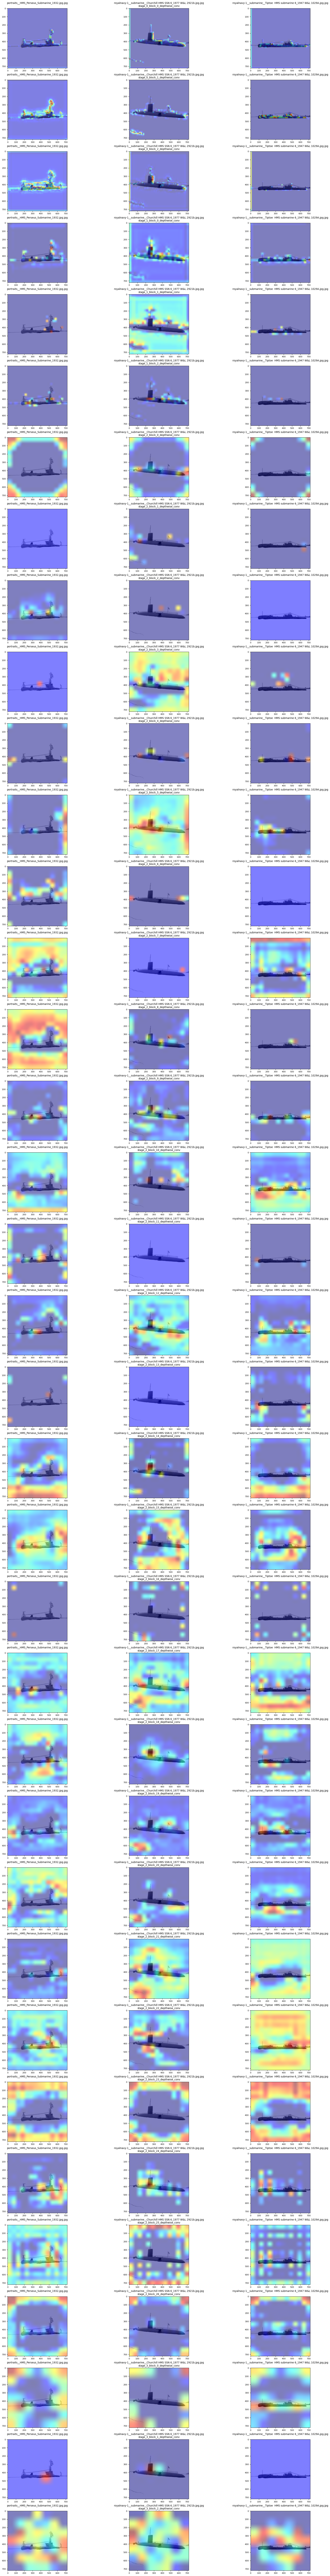

In [38]:
files = [
    "../data_prep/royalnavy/valid/submarine/portraits__HMS_Perseus_Submarine_1932.jpg.jpg",
    "../data_prep/royalnavy/valid/submarine/royalnavy-1__submarine__Churchill HMS SSN 6_1977 W&L 2921b.jpg.jpg",
    "../data_prep/royalnavy/valid/submarine/royalnavy-1__submarine__Tiptoe  HMS submarine 6_1947 W&L 1029A.jpg.jpg",
]
img_size = (224, 224, 3)
layers = [layer.name for layer in backbone.layers if "depthwise_conv" in layer.name]
plt.rcParams.update({'font.size': 8})

fig, axs = plt.subplots(len(layers), len(files), figsize=(8*len(files), 5*len(layers)))

for f, file in enumerate(files):
    for l, layer in enumerate(layers):
        gradcam_model = Model(
            inputs=backbone.input, 
            outputs=[backbone.get_layer(layer).output, backbone.output]
        )
        img_array = get_img_array(file, size=img_size)
        heatmap = make_gradcam_heatmap(gradcam_model, img_array)
        img = get_gradcam(file, heatmap)
        #img = tf.keras.utils.load_img(file)
        axs[l,f].imshow(img)
        tlt = f"{os.path.basename(file)}\n"
        if f == 1: tlt = f"{os.path.basename(file)}\n{layer.replace('convnext_large_', '')}"
        axs[l,f].title.set_text(tlt)

In [168]:
gradcam_model = Model(
    inputs=backbone.input, 
    outputs=[
        backbone.get_layer("convnext_large_stage_0_block_1_depthwise_conv").output, 
        backbone.output
    ]
)

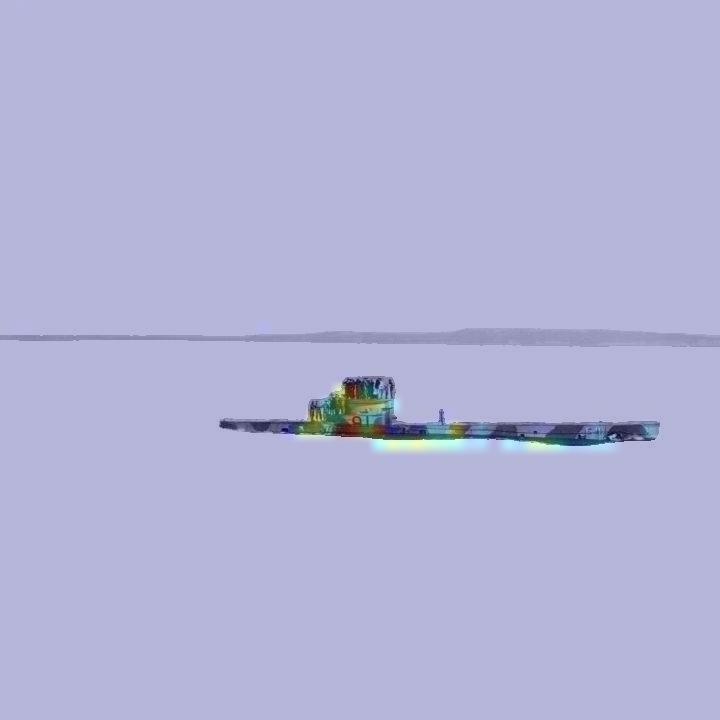

In [169]:
fn = "../data_prep/royalnavy/valid/submarine/portraits__HMS_Dardanelles_submarine.jpg.jpg"
img_size = (224, 224, 3)
img_array = get_img_array(fn, size=img_size)
heatmap = make_gradcam_heatmap(gradcam_model, img_array)
display_gradcam(fn, heatmap)

---